<CENTER>
</br>
<p><font size="5">  M2MO - XVA Analysis  </font></p>
<p><font size="5">  Project - Gap Risk </font></p>
<p><font size="4">  SANGLIER Nathan & PÉCHEUL Ronan </font></p>
<p><font size="3"></br>March 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@etu.u-paris.fr, ronan.pecheul@ensae.fr</span>
</p>
</CENTER>

----------------------------

In this project, we focus on computing numerically the CVA of a portfolio made of a unique interest rate swap. We assume the underlying rate process follows Black-Scholes dynamics. First, we derive analytical formulas for the CVA without RIM. We also compute this quantity using linear (neural network) regression and nested Monte-Carlo simulations. We then compute the CVA for a portfolio of one call option using polynomial regression, non-linear neural network regression, and nested Monte-Carlo simulations. The results are validated with the twin Monte-Carlo method. In a second part, we follow the same steps for the CVA with RIM, which involves quantile regression.

## <span style="color:#00B8DE"> 0 - Imports & Parameters </span>

\usepackage{amsmath}


In [55]:
import  torch
import  torch.nn                as      nn
import  numpy                   as      np
import  matplotlib.pyplot       as      plt
from    scipy.stats             import  norm
from    sklearn.linear_model    import  LinearRegression
from    sklearn.preprocessing   import  PolynomialFeatures
from    tqdm                    import  tqdm

In [56]:
np.random.seed(0)
torch.manual_seed(0)

The underlying process of our assets is a rate process $S$ which follows a Black-Scholes model:
$$
\begin{align*}
    dS_t = \kappa S_t dt + \sigma S_t dW_t.
\end{align*}
$$
We set the pricing dates to $t_n = n \delta$, $\forall n \in 0:N_T$, with $N_T = \frac{T}{\delta}$ as we will see that for each pricing date $t$, we need to compute $S_t$ and $S_{t^\delta}$ where $\delta$ is the time between default and portfolio liquidation. Moreover, we assume independent exponential default times with intensity $\gamma$ for the bank and its clients. We first generate $M = 5000$ trajectories of $S$.

In [57]:
r           = 0.02
S0          = 100
kappa       = 0.12
sigma       = 0.2
T           = 5
delta       = 1/52
gamma       = 0.1

time_grid   = np.arange(0, T+delta, delta)
N           = len(time_grid)-1
M           = 5000

def beta(t):
    return np.exp(-r*t)

In [58]:
def gen_S():
    '''Generate M paths of the underlying asset price'''
    paths           = np.zeros((M, N+1))
    paths[:, 0]     = S0
    Z               = np.random.normal(0, 1, size=(M, N))
    increments      = np.exp((kappa - 0.5 * sigma**2) * delta + sigma * np.sqrt(delta) * Z)
    paths[:, 1:]    = S0 * np.cumprod(increments, axis=1)
    return paths

S_paths = gen_S()

## <span style="color:#00B8DE"> I - CVA without RIM </span>

Let us denote $\text{MtM}$ the mark-to-market process of our assets with underlying $S$ and maturity $T$, so $\text{MtM}_t = 0$ $\forall t \ge T$. We assume first that the CVA is computed without receiving initial margin. Thus, it is defined at time $0$ as:
$$
\text{CVA}_0 = \gamma \cdot \mathbb{E}\left[\int_0^T \mathbb{E}_t\left[\text{MtM Gap}^+_{t^\delta}\right] e^{-\gamma t} dt\right],
$$
where $\forall t \le T$ we have:
$$
\text{MtM Gap}^+_{t^\delta} = \left(\text{MtM Gap}_{t^\delta}\right)^+,
$$
and
$$
\text{MtM Gap}_{t^\delta} = \beta_{t^\delta}(\text{MtM}_{t^\delta} + \Delta_{t^\delta}) - \beta_t \text{MtM}_t,
$$
with $\forall t \ge T$, $\Delta_t = 0$ so that $\text{MtM Gap}_t = 0$.

### <span style="color:#008000"> Interest Rate Swap

In the following questions, we consider a portfolio made of a unique interest rate swap with a fixed rate $\bar S$ and a notional $\text{Nom}$, and the $\text{MtM}$ process of a long position in this swap is given by $\forall t < T$:
$$
\text{MtM}_t = \text{Nom} \cdot h \cdot \beta_t^{-1} \cdot \left( \beta_{T_{l_t}}(S_{T_{l_t-1}} - \bar S) + \sum_{l=l_t+1}^d \beta_{T_l} (e^{\kappa T_{l-1}} \hat S_t - \bar S)\right),
$$
$\bar S$ is such that:
$$
\begin{align*}
    \text{MtM}_0 = 0 &\Leftrightarrow  \beta_{T_1} (S_0 - \bar S) + \sum_{l=2}^d \beta_{T_l} (e^{\kappa T_{l-1}} S_0 - \bar S) = 0 \\
    &\Leftrightarrow \bar S = S_0 \cdot \frac{\sum_{l=1}^d \beta_{T_l} e^{\kappa T_{l-1}}}{\sum_{l=1}^d \beta_{T_l}}.
\end{align*}
$$
Moreover, the nominal of the swap is set so that each leg has a time-$0$ $\text{MtM}$ of one, ie $10^4$ bp:
$$
\begin{align*}
\text{fix leg}_0 = 1 &\Leftrightarrow \text{Nom} \cdot h \cdot \bar S \cdot \sum_{l=1}^d \beta_{T_l} = 1 \\
&\Leftrightarrow \text{Nom} = \frac{1}{h \cdot \bar S \cdot \sum_{l=1}^d \beta_{T_l}}.
\end{align*}
$$

In [59]:
h                       = 0.25
swap_grid               = np.arange(0, T+h, h)
d                       = len(swap_grid)-1

map_time_to_swap_inds   = np.searchsorted(swap_grid, time_grid, side='right') # l_{t} for t in time_grid
map_swap_to_time_inds   = np.where(np.isin(time_grid, swap_grid))[0] # indices of T_{l} in time_grid

Sbar                    = S0 * np.sum(beta(swap_grid[1:]) * np.exp(kappa*swap_grid[:-1])) / np.sum(beta(swap_grid[1:]))  
nom                     = 10**4 / (h * Sbar * np.sum(beta(swap_grid[1:])))

Let us verify that $\bar S$ and $\text{Nom}$ are well defined by generating $M$ trajectories of $\text{MtM}$ and displaying some statistics.

In [60]:
def gen_mtm_swap(S_paths):
    '''Generate paths of the MtM swap process based on the underlying asset price paths'''
    M   = S_paths.shape[0]
    mtm = np.zeros((M, N+1))
    for i in range(N):
        lt          = map_time_to_swap_inds[i]
        part_sum    = np.sum(beta(swap_grid[lt+1:])*(np.exp(kappa*(swap_grid[lt:-1] - time_grid[i]))*S_paths[:, i].reshape(-1, 1) - Sbar), axis=1)
        mtm[:, i]   = h*nom/beta(time_grid[i]) * (beta(swap_grid[lt])*(S_paths[:, map_swap_to_time_inds[lt-1]] - Sbar) + part_sum)
    return mtm

mtm_swap_paths  = gen_mtm_swap(S_paths)

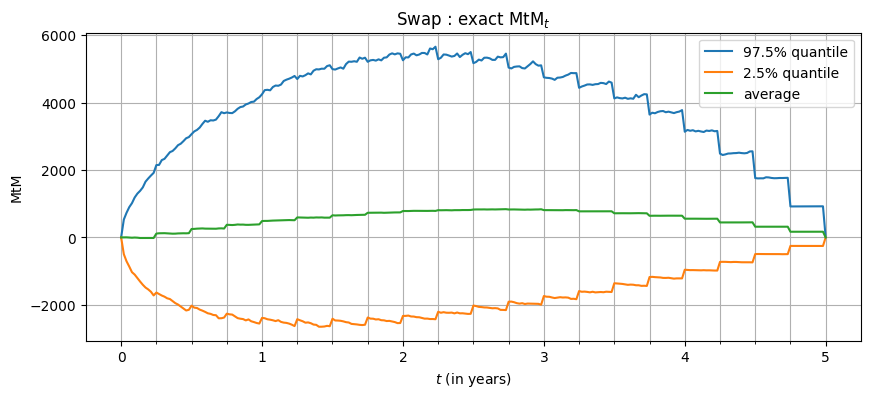

In [61]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, np.quantile(mtm_swap_paths, 0.975, axis=0), label='97.5% quantile')
ax.plot(time_grid, np.quantile(mtm_swap_paths, 0.025, axis=0), label='2.5% quantile')
ax.plot(time_grid, np.mean(mtm_swap_paths, axis=0), label='average')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('MtM')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('Swap : exact $\\text{MtM}_t$')
ax.legend()
plt.show()

#### <span style="color:#00B8DE"> Question 1.1. </span>

In order to compute the CVA, we want to learn the function $u_t$ for each pricing time $t \le T$  such that:
$$
u_t(S_t) = \mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right].
$$
In the case of the swap, we won't start from the generic expression of $\text{MtM Gap}$ but from the following formula (at the cost of a small approximation) $\forall t<T$:
$$
\text{MtM Gap}_{t^\delta}= \text{Nom} \cdot f(t) \cdot (\hat S_{t^\delta} - \hat S_t).
$$

We know that $u_t = \arg\min_{h \in \mathcal{B}} \mathbb{E}\left[\left(\text{MtM Gap}_{t^\delta}^+-h(S_t)\right)^2\right]$ and we will approximate this function with a linear regression model and a one layer linear neural network (for each pricing date). Our data consists of $M$ simulated iid samples of $(S_t^{(m)}, \text{MtM Gap}_{t^\delta}^{+ (m)})$ for each pricing date $t$.

For the linear regression model, we approximate $u_t$ by $\hat u_t^{\text{LR}}(S) = \beta^{\text{LR}}(t) \cdot S$, with $\beta^{\text{LR}}(t)$ being the following OLS estimator:
$$
\begin{align*}
    \beta^{\text{LR}}(t) 
    &= \arg\min_{\beta \in \mathbb{R}} \sum_{m=1}^M \left(\text{MtM Gap}_{t^\delta}^{+ (m)} - \beta \cdot S_t^{(m)}\right)^2, \\
    &= \frac{\sum_{m=1}^M \text{MtM Gap}_{t^\delta}^{+ (m)} \cdot S_t^{(m)}}{\sum_{m=1}^M (S_t^{(m)})^2}.
\end{align*}
$$

For the one layer linear neural network, we approximate $u_t$ by $\hat u_t^{\text{LNN}}(S) = \beta^{\text{LNN}}(t) \cdot S$, with $\beta^{\text{LNN}}(t)$ being the following estimator:
$$
\beta^{\text{LNN}}(t) \approx \arg\min_{\beta \in \mathbb{R}} \sum_{m=1}^M \left(\text{MtM Gap}_{t^\delta}^{+ (m)} - h_{\beta}\left(S_t^{(m)}\right)\right)^2,
$$
where $h_{\beta}$ is the neural network function with parameter $\beta$, and the minimization is done with a gradient descent algorithm.

Notice that we use linear models because we have theoretically the folllowing linear relationship for the swap:
$$
\begin{align*}
    \mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right]
    &= u_t(S_t), \\
    &= \text{Nom} \cdot A(t) \cdot \hat S_t, \notag \\
    &= \beta^{\text{true}}(t) \cdot S_t,
\end{align*}
$$
where $\beta^{\text{true}}(t) = \text{Nom} \cdot A(t) \cdot e^{-\kappa t}$.

Let us first generate our sample trajectories of $\text{MtM Gap}^+$.

In [62]:
def f(i):
    lt_delta = map_time_to_swap_inds[i+1]
    return h * np.sum(beta(swap_grid[lt_delta+1:])*np.exp(kappa*(swap_grid[lt_delta:-1])))

f_vals = np.array([f(i) for i in range(N)])

def gem_mg_swap(S_paths):
    '''Generates paths of the MtM gap swap process based on the (approximated) formula'''
    mtm_gap = nom*f_vals*np.diff(S_paths*np.exp(-kappa*time_grid), axis=1)
    mtm_gap = np.concatenate((mtm_gap, np.zeros((M, 1))), axis=1)
    return mtm_gap

mg_swap_paths   = gem_mg_swap(S_paths)
mgp_swap_paths  = np.maximum(mg_swap_paths, 0)

We train a linear regression model at each pricing date $t$ using $\left(S_t^{(m)}, \text{MtM Gap}_{t^\delta}^{+ (m)}\right)_m$ and calculate the paths $\left(\hat u_t^{\text{LR}}(S_t)\right)$ for our different trajectories of $(S_t)$.

In [63]:
econd_mgp_swap_lr_paths = np.zeros_like(S_paths)
beta_vals_lr            = np.zeros(N+1)
for i in range(N+1):
    model = LinearRegression(fit_intercept=False)
    model.fit(S_paths[:, i].reshape(-1, 1), mgp_swap_paths[:, i])
    beta_vals_lr[i]                 = model.coef_[0]
    econd_mgp_swap_lr_paths[:, i]   = model.predict(S_paths[:, i].reshape(-1, 1))

We do the same for the one layer linear neural network. Notice that for simplicity here, we do not standardize the data as we know we should get a linear relationship with no intercept. Thus, the learning rate is set to $10^{-5}$ to reflect the scale of the data.

In [64]:
class LinearNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1, bias=False)
    def forward(self, x):
        return self.linear(x)

econd_mgp_swap_lnn_paths    = np.zeros_like(S_paths)
beta_vals_lnn               = np.zeros(N+1)
nepochs                     = 100
train_losses_swap_lnn       = np.zeros((N+1, nepochs))
for i in tqdm(range(N), desc='Training linear neural network'):
    x       = torch.tensor(S_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    y       = torch.tensor(mgp_swap_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    model   = LinearNN()
    crit    = nn.MSELoss()
    optim   = torch.optim.Adam(model.parameters(), lr=5*10**(-2))
    for epoch in range(nepochs):
        model.train()
        optim.zero_grad()
        loss = crit(model(x), y)
        loss.backward()
        optim.step()
        train_losses_swap_lnn[i, epoch] = loss.item()
    beta_vals_lnn[i]                = model.linear.weight.item()
    econd_mgp_swap_lnn_paths[:, i]  = model(x).detach().numpy().reshape(-1)

Training linear neural network: 100%|██████████| 260/260 [00:18<00:00, 14.31it/s]


#### <span style="color:#00B8DE"> Question 1.2. </span>

How to validate our results obtained in the previous question ? First, we can compare $\beta^{LR}$ and $\beta^{LNN}$ with $\beta^{\text{true}}$ for each pricing date $t$ and see if we get the same values. Let us compute the true values of $\beta$ as well as the true paths $(u_t(S_t))$ for our trajectories $(S_t)$ since we have the analytical formula.

In [65]:
def A(i):
    return f_vals[i] * (norm.cdf(sigma*np.sqrt(delta)/2) - norm.cdf(-sigma*np.sqrt(delta)/2))

A_vals      = np.array([A(i) for i in range(N)])
beta_vals   = nom * A_vals * np.exp(-kappa*time_grid[:-1])
beta_vals   = np.concatenate((beta_vals, np.zeros(1)))

def gen_econd_mgp_swap(S_paths):
    '''Generates paths of the conditional expectation of the MtM gap swap process based on the formula'''
    return beta_vals * S_paths

econd_mgp_swap_paths = gen_econd_mgp_swap(S_paths)

For each method, we now display the estimated coefficient $(\beta(t))_t$ of the linear relationship and show the MSE with $(\beta^\text{true}(t))_t$.

MSE beta LNN: 0.0002
MSE beta LR: 0.0002


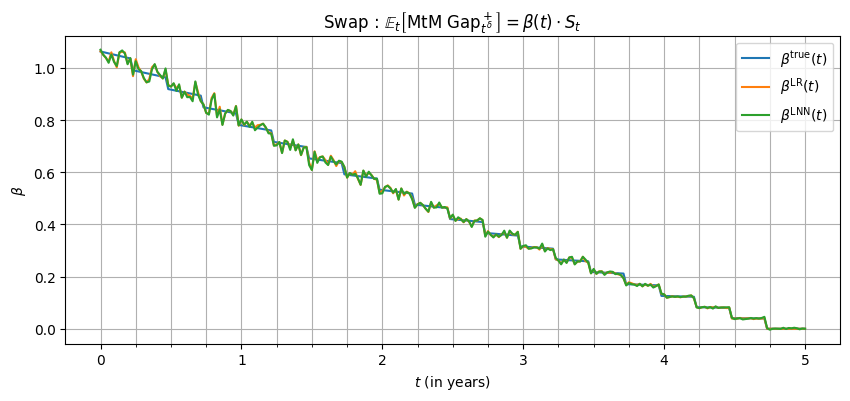

In [66]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, beta_vals, label='$\\beta^{\\text{true}}(t)$')
ax.plot(time_grid, beta_vals_lr, label='$\\beta^{\\text{LR}}(t)$')
ax.plot(time_grid, beta_vals_lnn, label='$\\beta^{\\text{LNN}}(t)$')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('$\\beta$')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('Swap : $\\mathbb{E}_t\\left[\\text{MtM Gap}_{t^\\delta}^+\\right] = \\beta(t) \\cdot S_t$')
ax.legend()
print(f"MSE beta LNN: {np.mean((beta_vals - beta_vals_lnn)**2):.4f}")
print(f"MSE beta LR: {np.mean((beta_vals - beta_vals_lr)**2):.4f}")
plt.show()

If we did not had access to the explicit formula of $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right]$, we could still validate our results with a twin Monte-Carlo method. Indeed, it can be shown that the regression error at time $t$ is given by:
$$
\mathbb{E}\left[\left(\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right] - \hat u_t(S_t)\right)^2\right]
= \mathbb{E}\left[\hat u_t(S_t)^2 - (\text{MtM Gap}_{t^\delta}^{+ (1)} + \text{MtM Gap}_{t^\delta}^{+ (2)}) \cdot \hat u_t(S_t) + \text{MtM Gap}_{t^\delta}^{+ (1)} \cdot \text{MtM Gap}_{t^\delta}^{+ (2)}\right],
$$
where $\text{MtM Gap}_{t^\delta}^{+ (1)}$ and $\text{MtM Gap}_{t^\delta}^{+ (2)}$ are two iid samples of $\text{MtM Gap}_{t^\delta}^+$ knowing $S_t$:
$$
\text{MtM Gap}_{t^\delta}^{+ (1)/(2)} = \left(\text{MtM Gap}_{t^\delta}^{(1)/(2)}\right)^+,
$$
and
$$
\text{MtM Gap}_{t^\delta}^{(1)/(2)} = \text{Nom} \cdot f(t) \cdot (\hat S_{t^\delta}^{(1)/(2)} - \hat S_t),
$$
with $S_{t^\delta}^{(1)/(2)} = S_t e^{(\kappa - \frac{1}{2} \sigma^2) \delta + \sigma \sqrt{\delta} Z^{(1)/(2)}}$.
We can then approximate the regression error with an empirical mean.

Since the linear regression model and the neural network produce the same results, let us do the analysis for the linear regression model. We first generate the "twin" paths of $\text{MtM Gap}^+$, ie the paths of $\text{MtM Gap}^{+ (2)}$. Notice that we will use for $\text{MtM Gap}^{+ (1)}$ the initial trajectories of $\text{MtM Gap}^+$ so that we only need to generate one sample. We then compute the regression error in the way described above.

In [67]:
def gen_mg_twin_swap(S_paths):
    mtm_gap = np.zeros_like(S_paths)
    for i in range(N):
        new_point       = S_paths[:, i]*np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*np.random.normal(0, 1, size=M))
        mtm_gap[:, i]   = nom*f_vals[i]*(np.exp(-kappa*time_grid[i+1])*new_point-np.exp(-kappa*time_grid[i])*S_paths[:, i])
    return mtm_gap

mg_twin_swap_paths  = gen_mg_twin_swap(S_paths)
mgp_twin_swap_paths = np.maximum(mg_twin_swap_paths, 0)
regerr_swap_lr_twin = np.mean(econd_mgp_swap_lr_paths**2 - (mgp_twin_swap_paths+mgp_swap_paths)*econd_mgp_swap_lr_paths + mgp_twin_swap_paths*mgp_swap_paths, axis=0)
regerr_swap_lr_true = np.mean((econd_mgp_swap_lr_paths - econd_mgp_swap_paths)**2, axis=0)

In order to check that our twin Monte-Carlo trick is working well, we can compare the regression error from twin smimulation with the "true" regression error. Indeed, we have access to the formula of $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right]$, and we can replace the outer expectation by an empirical mean.

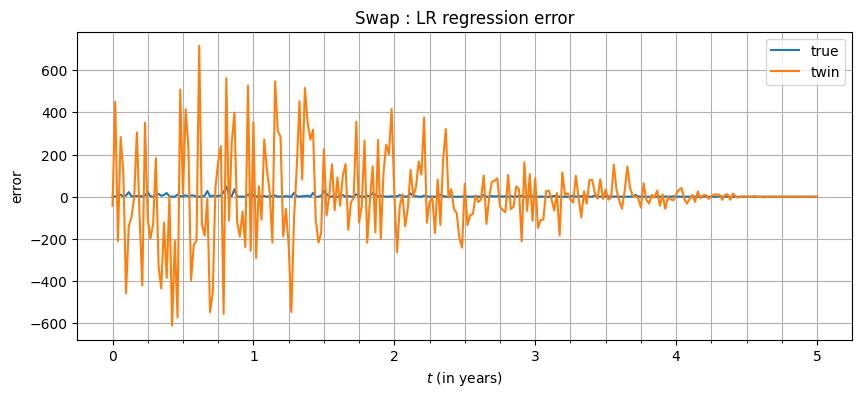

In [68]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, regerr_swap_lr_true, label='true')
ax.plot(time_grid, regerr_swap_lr_twin, label='twin')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('error')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.legend()
ax.set_title('Swap : LR regression error')
plt.show()

Finally, we can validate our estimations of $u_t$ by comparing them with a nested Monte-Carlo simulation. This apprach only works for validating one trajectory of the approximated $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right]$, ie $\hat u_t(S_t)$, but not for validating the whole function $\hat u_t$. Given a trajectory $(S_t)$, we do the following approximation at each pricing date $t$:
$$
\begin{align*}
\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right] \approx \frac{1}{K} \sum_{k=1}^K \text{MtM Gap}_{t^\delta}^{+ (k)},
\end{align*}
$$
where $\text{MtM Gap}_{t^\delta}^{+ (k)}$ are $K$ iid samples of $\text{MtM Gap}_{t^\delta}^+$ knowing $S_t$, as for the twin Monte-Carlo method. Thus, we generate $K = \sqrt{M}$ new samples of $\text{MtM Gap}_{t^\delta}^+$ for each pricing date $(t, S_t)$. We did choose $K = \sqrt{M}$ as we will also do a Monte-Carlo simulation for calculating $CVA_0$ based on the Monte-Carlo simulation of $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right]$ (hence the "nested" term). One can show that it does not improve the accuracy of $CVA$ to use more than $\sqrt{M}$ samples.

In [69]:
def gen_econd_mgp_swap_nmc(S_paths):
    res = np.zeros_like(S_paths)
    for i in tqdm(range(N), desc='Processing nested Monte Carlo'):
        new_points  = S_paths[:, i]*np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*np.random.normal(0, 1, size=(int(np.sqrt(M)), len(S_paths))))
        res[:, i]   = np.mean(np.maximum(nom*f_vals[i]*(np.exp(-kappa*time_grid[i+1])*new_points-np.exp(-kappa*time_grid[i])*S_paths[:, i]), 0), axis=0)
    return res

econd_mgp_swap_nmc_paths = gen_econd_mgp_swap_nmc(S_paths)

Processing nested Monte Carlo: 100%|██████████| 260/260 [00:04<00:00, 52.89it/s]


Let us display our estimates of $u_t(S_t)$.

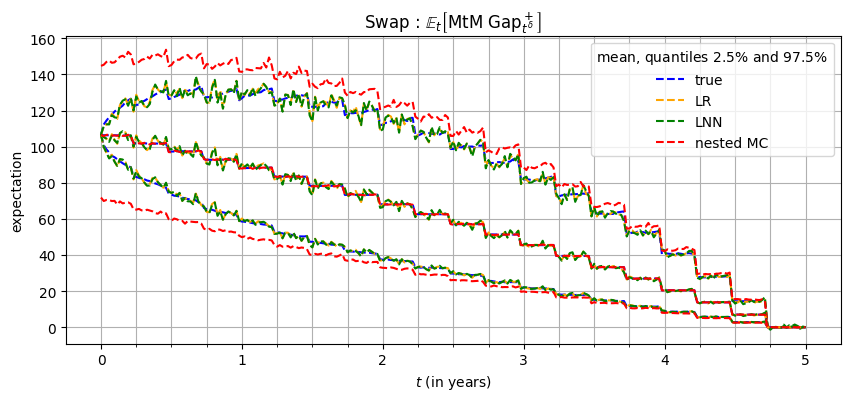

In [70]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, np.quantile(econd_mgp_swap_paths, 0.975, axis=0), label='true', linestyle='--', color='blue')
ax.plot(time_grid, np.quantile(econd_mgp_swap_lr_paths, 0.975, axis=0), label='LR', linestyle='--', color='orange')
ax.plot(time_grid, np.quantile(econd_mgp_swap_lnn_paths, 0.975, axis=0), label='LNN', linestyle='--', color='green')
ax.plot(time_grid, np.quantile(econd_mgp_swap_nmc_paths, 0.975, axis=0), label='nested MC', linestyle='--', color='red')

ax.plot(time_grid, np.quantile(econd_mgp_swap_paths, 0.025, axis=0), linestyle='--', color='blue')
ax.plot(time_grid, np.quantile(econd_mgp_swap_lr_paths, 0.025, axis=0), linestyle='--', color='orange')
ax.plot(time_grid, np.quantile(econd_mgp_swap_lnn_paths, 0.025, axis=0), linestyle='--', color='green')
ax.plot(time_grid, np.quantile(econd_mgp_swap_nmc_paths, 0.025, axis=0), linestyle='--', color='red')

ax.plot(time_grid, np.mean(econd_mgp_swap_paths, axis=0), linestyle='--', color='blue')
ax.plot(time_grid, np.mean(econd_mgp_swap_lr_paths, axis=0), linestyle='--', color='orange')
ax.plot(time_grid, np.mean(econd_mgp_swap_lnn_paths, axis=0), linestyle='--', color='green')
ax.plot(time_grid, np.mean(econd_mgp_swap_nmc_paths, axis=0), linestyle='--', color='red')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('expectation')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('Swap : $\\mathbb{E}_t\\left[\\text{MtM Gap}_{t^\\delta}^+\\right]$')
ax.legend(title='mean, quantiles $2.5\\%$ and $97.5\\%$')
plt.show()

We see that the estimations for nested Monte-Carlo do not perform as well as the other methods. This is due to the fact that we only use $K = \sqrt{M}$ samples for each pricing date $t$. At the end, when calculating the CVA, it won't make any difference.

#### <span style="color:#00B8DE"> Question 1.3. </span>

Now, the CVA can be computed using our previous estimators $\hat u_t(S_t)$ of $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right]$, approximating the integral numerically, and taking an empirical mean over our $M$ iid samples $\hat u_t(S_t^{(m)})$.

Notice that we can validate our results using empirical mean for the outer expecation and the formula or nested Monte-Carlo simulation for the inner conditional expectation, but also using the following formula for a swap:
$$
\text{CVA}_0 = \text{Nom} \cdot S_0 \cdot \gamma \cdot \int_0^T A(t) \cdot e^{-\gamma t} dt.
$$

In [71]:
cva_swap = nom*S0*np.trapezoid(A_vals * np.exp(-gamma*time_grid[:-1]) * gamma, dx=delta)

In [72]:
def calc_cva(econd_mgp_paths):
    'Calculates the CVA based on the estimation of conditional expectation of the MtM gap process'
    CVA_vals = np.trapezoid(econd_mgp_paths * np.exp(-gamma*time_grid) * gamma, dx=delta, axis=1)
    return np.mean(CVA_vals)

cva_swap_mc     = calc_cva(econd_mgp_swap_paths)
cva_swap_lr     = calc_cva(econd_mgp_swap_lr_paths)
cva_swap_lnn    = calc_cva(econd_mgp_swap_lnn_paths)
cva_swap_nmc    = calc_cva(econd_mgp_swap_nmc_paths)

print(f"CVA swap formula: {cva_swap:.4f}")
print(f"CVA swap using MC for outer expectation and formula for conditional expectation: {cva_swap_mc:.4f}")
print(f"CVA swap using MC for outer expectation and LR for conditional expectation: {cva_swap_lr:.4f}")
print(f"CVA swap using MC for outer expectation and LNN for conditional expectation: {cva_swap_lnn:.4f}")
print(f"CVA swap using MC for outer expectation and nested MC for conditional expectation: {cva_swap_nmc:.4f}")

CVA swap formula: 24.0534
CVA swap using MC for outer expectation and formula for conditional expectation: 24.1339
CVA swap using MC for outer expectation and LR for conditional expectation: 24.1530
CVA swap using MC for outer expectation and LNN for conditional expectation: 24.1253
CVA swap using MC for outer expectation and nested MC for conditional expectation: 24.1292


### <span style="color:#008000"> Interest Rate Call Option

In the following questions, we consider a portfolio made of an interest rate call option ATM $(K=S_0)$ instead of the swap. The MtM process of a long position in this call option is given by the well-known Black-Scholes formula $\forall t < T$:
$$
\text{MtM}_t = e^{-r (T-t)} \left(e^{\kappa (T-t)} S_t \mathcal{N}(d_+) - S_0 \mathcal{N}(d_-)\right),
$$
with $d_\pm = \frac{\log(S_t/S_0) + (\kappa \pm \frac{1}{2} \sigma^2)(T-t)}{\sigma \sqrt{T-t}}$.

#### <span style="color:#00B8DE"> Question 4. </span>

In the case of the call, we do not have anymore the explicit formulas for verfying our estimations of $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right]$ and $\text{CVA}_0$. Moreover, we will start from the generic expression of $\text{MtM Gap}$, but noticing $\Delta_{t^\delta} = 0$:
$$
\text{MtM Gap}_{t^\delta} = \left(\beta_{t^\delta} \text{MtM}_{t^\delta} - \beta_t \text{MtM}_t\right),
$$
with $\text{MtM}$ given as above.

We do not expect to have a linear function $u_t(S_t) = \mathbb{E}_t\left[\text{MtM Gap}^+_{t^\delta}\right]$ anymore. Thus, we will approximate this function with a polynomial regression model and a non-linear neural network. Our results will be validated with twin Monte-Carlo method and nested Monte-Carlo simulation, as in the previous questions (but loosing analytical formulas).

Let us first generate our sample trajectories of $\text{MtM Gap}^+$.

In [73]:
def gen_mtm_call(S_paths):
    '''Generate paths of the MtM call process based on the underlying asset price paths'''
    M   = S_paths.shape[0]
    MtM = np.zeros((M, N+1))
    for i in range(N):
        d1          = (np.log(S_paths[:, i]/S0) + (kappa + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i])
        MtM[:, i]   = np.exp(-r*(T-time_grid[i]))*(S_paths[:, i]*np.exp(kappa*(T-time_grid[i]))*norm.cdf(d1) - S0*norm.cdf(d2))
    return MtM

def gen_mg_call(mtm_paths):
    '''Generates paths of the positive part of the MtM gap call process based on definition of MtM gap'''
    return np.concatenate((np.diff(beta(time_grid)*mtm_paths), np.zeros((M, 1))), axis=1)

mtm_call_paths  = gen_mtm_call(S_paths)
mg_call_paths   = gen_mg_call(mtm_call_paths)
mgp_call_paths  = np.maximum(mg_call_paths, 0)

We train a polynomial regression model at each pricing date $t$ using $\left(S_t^{(m)}, \text{MtM Gap}_{t^\delta}^{+ (m)}\right)_m$ and calculate the paths $\left(u_t^{\text{PR}}(S_t)\right)$ for our different trajectories of $(S_t)$.

In [74]:
econd_mgp_call_pr_paths = np.zeros((M, N+1))
for i in range(N):
    model   = LinearRegression(fit_intercept=False)
    poly    = PolynomialFeatures(degree=3, include_bias=True)
    S_poly  = poly.fit_transform(S_paths[:, i].reshape(-1, 1))
    model.fit(S_poly, mgp_call_paths[:, i])
    econd_mgp_call_pr_paths[:, i] = model.predict(S_poly)

We do the same for the non-linear neural network, producing $\left(u_t^{\text{NLNN}}(S_t)\right)$. We have chosen a neural network with one hidden layer of $10$ neurons and a ReLU activation function.

In [75]:
class NonLinearNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden     = nn.Linear(input_dim, 10)
        self.output     = nn.Linear(10, 1)
        self.activation = nn.ReLU()
    def forward(self, x):
        x = self.activation(self.hidden(x))
        x = self.output(x)
        return x

econd_mgp_call_nlnn_paths   = np.zeros((M, N+1))
nepochs                     = 200
train_losses_call_nlnn      = np.zeros((N+1, nepochs))
for i in tqdm(range(N), desc='Training nonlinear neural network'):
    x       = torch.tensor(S_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    x       = (x - x.mean())/x.std() if x.std() > 0 else x
    y       = torch.tensor(mgp_call_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    model   = NonLinearNN(input_dim=1)
    crit    = nn.MSELoss()
    optim   = torch.optim.Adam(model.parameters(), lr=10**(-2))
    for epoch in range(nepochs):
        model.train()
        optim.zero_grad()
        loss = crit(model(x), y)
        loss.backward()
        optim.step()
        train_losses_call_nlnn[i, epoch] = loss.item()
    econd_mgp_call_nlnn_paths[:, i] = model(x).detach().numpy().reshape(-1)

Training nonlinear neural network: 100%|██████████| 260/260 [01:30<00:00,  2.86it/s]


Let us validate our results with a twin Monte-Carlo method as in Question 2.

In [76]:
def gen_mg_twin_call(S_paths):
    mtm_gap = np.zeros_like(S_paths)
    for i in range(N):
        d1              = (np.log(S_paths[:, i]/S0) + (kappa + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2              = d1 - sigma*np.sqrt(T-time_grid[i])
        mtm             = np.exp(-r*(T-time_grid[i]))*(S_paths[:, i]*np.exp(kappa*(T-time_grid[i]))*norm.cdf(d1) - S0*norm.cdf(d2))
        new_point       = S_paths[:, i]*np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*np.random.normal(0, 1, size=M))
        new_mtm         = np.exp(-r*(T-time_grid[i+1]))*(new_point*np.exp(kappa*(T-time_grid[i+1]))*norm.cdf(d1) - S0*norm.cdf(d2))
        mtm_gap[:, i]   = beta(time_grid[i+1])*new_mtm - beta(time_grid[i])*mtm
    return mtm_gap

mg_twin_call_paths  = gen_mg_twin_call(S_paths)
mgp_twin_call_paths = np.maximum(mg_twin_call_paths, 0)
regerr_call_pr_twin = np.mean(econd_mgp_call_pr_paths**2 - (mgp_twin_call_paths+mgp_call_paths)*econd_mgp_call_pr_paths + mgp_twin_call_paths*mgp_call_paths, axis=0)

Notice that here, we do not have access to the "true" regression error as we do not have explicit expression for $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right]$.

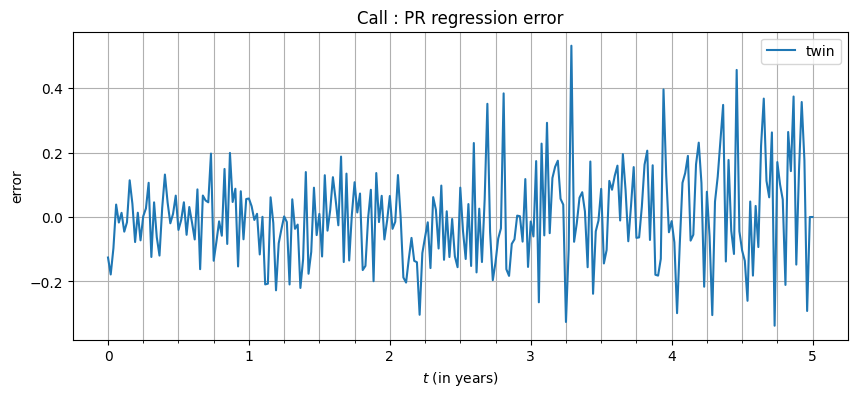

In [77]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, regerr_call_pr_twin, label='twin')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('error')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('Call : PR regression error')
ax.legend()
plt.show()

Finally, we can validate our estimations of $u_t$ by comparing them with a nested Monte-Carlo simulation.

In [78]:
def gen_econd_mgp_call_nmc(S_paths):
    res = np.zeros_like(S_paths)
    for i in tqdm(range(N-1), desc='Processing nested Monte Carlo'):
        d1          = (np.log(S_paths[:, i]/S0) + (kappa + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i])
        mtm         = np.exp(-r*(T-time_grid[i]))*(S_paths[:, i]*np.exp(kappa*(T-time_grid[i]))*norm.cdf(d1) - S0*norm.cdf(d2))
        new_points  = S_paths[:, i]*np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*np.random.normal(0, 1, size=(int(np.sqrt(M)), len(S_paths))))
        d1          = (np.log(new_points/S0) + (kappa + 0.5*sigma**2)*(T-time_grid[i+1])) / (sigma*np.sqrt(T-time_grid[i+1]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i+1])
        new_mtms    = np.exp(-r*(T-time_grid[i+1]))*(new_points*np.exp(kappa*(T-time_grid[i+1]))*norm.cdf(d1) - S0*norm.cdf(d2))
        new_gap     = beta(time_grid[i+1])*new_mtms - beta(time_grid[i])*mtm
        res[:, i]   = np.mean(np.maximum(new_gap, 0), axis=0)
    return res

econd_mgp_call_nmc_paths = gen_econd_mgp_call_nmc(S_paths)

Processing nested Monte Carlo: 100%|██████████| 259/259 [00:20<00:00, 12.40it/s]


Let us display our estimates of $u_t(S_t)$.

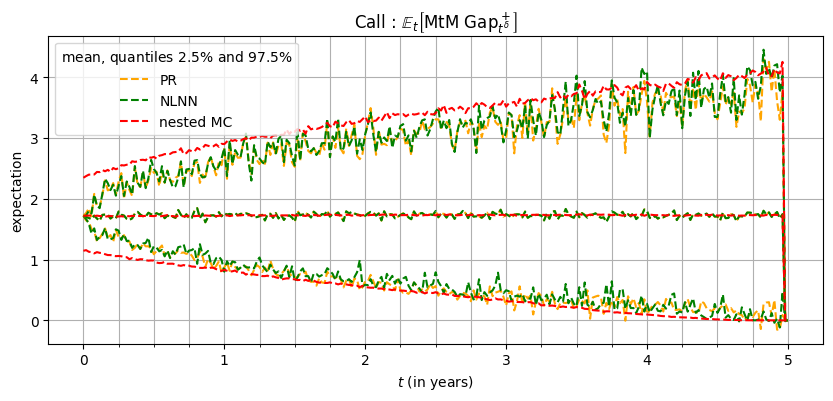

In [79]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, np.quantile(econd_mgp_call_pr_paths, 0.975, axis=0), label='PR', linestyle='--', color='orange')
ax.plot(time_grid, np.quantile(econd_mgp_call_nlnn_paths, 0.975, axis=0), label='NLNN', linestyle='--', color='green')
ax.plot(time_grid, np.quantile(econd_mgp_call_nmc_paths, 0.975, axis=0), label='nested MC', linestyle='--', color='red')

ax.plot(time_grid, np.quantile(econd_mgp_call_pr_paths, 0.025, axis=0), linestyle='--', color='orange')
ax.plot(time_grid, np.quantile(econd_mgp_call_nlnn_paths, 0.025, axis=0), linestyle='--', color='green')
ax.plot(time_grid, np.quantile(econd_mgp_call_nmc_paths, 0.025, axis=0), linestyle='--', color='red')

ax.plot(time_grid, np.mean(econd_mgp_call_pr_paths, axis=0), linestyle='--', color='orange')
ax.plot(time_grid, np.mean(econd_mgp_call_nlnn_paths, axis=0), linestyle='--', color='green')
ax.plot(time_grid, np.mean(econd_mgp_call_nmc_paths, axis=0), linestyle='--', color='red')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('expectation')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('Call : $\\mathbb{E}_t\\left[\\text{MtM Gap}_{t^\\delta}^+\\right]$')
ax.legend(title='mean, quantiles $2.5\\%$ and $97.5\\%$')
plt.show()

#### <span style="color:#00B8DE"> Question 5. </span>

As in Question 3., the CVA can be computed using our previous estimators $\hat u_t(S_t)$ of $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right]$, approximating the integral numerically, and taking an empirical mean over our $M$ iid samples $\hat u_t(S_t^{(m)})$.

Notice that we can validate our results using empirical mean for the outer expecation and nested Monte-Carlo simulation for the inner conditional expectation, but also using the following Monte-Carlo companion procedure:
$$
\begin{align*}
    \text{CVA}_0
    &= \gamma \cdot \mathbb{E}\left[\int_0^T \mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right] e^{-\gamma t} dt\right], \\
    &= \gamma \cdot \int_0^T \mathbb{E}\left[\text{MtM Gap}_{t^\delta}\right] e^{-\gamma t} dt, \\
    &\approx \gamma \cdot \int_0^T \frac{1}{M} \sum_{m=1}^M \text{MtM Gap}_{t^\delta}^{(m)} e^{-\gamma t} dt.
\end{align*}
$$

In [80]:
cva_call_cmc    = np.trapezoid(np.mean(mgp_call_paths, axis=0) * np.exp(-gamma*time_grid) * gamma, dx=delta)
cva_call_pr     = calc_cva(econd_mgp_call_pr_paths)
cva_call_nlnn   = calc_cva(econd_mgp_call_nlnn_paths)
cva_call_nmc    = calc_cva(econd_mgp_call_nmc_paths)    

print(f"CVA call using companion MC: {cva_call_cmc:.4f}")
print(f"CVA call using MC for outer expectation and PR for conditional expectation: {cva_call_pr:.4f}")
print(f"CVA call using MC for outer expectation and NLNN for conditional expectation: {cva_call_nlnn:.4f}")
print(f"CVA call using MC for outer expectation and nested MC for conditional expectation: {cva_call_nmc:.4f}")

CVA call using companion MC: 0.6772
CVA call using MC for outer expectation and PR for conditional expectation: 0.6772
CVA call using MC for outer expectation and NLNN for conditional expectation: 0.6771
CVA call using MC for outer expectation and nested MC for conditional expectation: 0.6768


## <span style="color:#00B8DE"> II - CVA with RIM </span>

We now assume the CVA is computed by taking into account the initial margin received. Thus, it is defined at time $0$ as:
$$
\text{CVA}^{\text{rim}}_0 = \gamma \cdot \mathbb{E}\left[\int_0^T \mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right] e^{-\gamma t} dt\right],
$$
where $\forall t < T$ we have:
$$
\text{MtM Gap}^{\text{rim} +}_{t^\delta} = \left(\text{MtM Gap}^{\text{rim}}_{t^\delta}\right)^+,
$$
and
$$
\begin{align*}
    \text{MtM Gap}^{\text{rim}}_{t^\delta}
    &= \beta_{t^\delta}(\text{MtM}_{t^\delta} + \Delta_{t^\delta}) - \beta_t (\text{MtM}_t + \text{RIM}_t),
\end{align*}
$$
with $\text{MtM Gap}^{\text{rim}}_{T^\delta} = 0$. Moreover,
$$
\beta_t \text{RIM}_t = \left(\mathbb{V}\text{a}\mathbb{R}_t^a(\beta_{t^\delta}(\text{MtM}_{t^\delta} + \Delta_{t^\delta}) - \beta_t \text{MtM}_t)\right)^+.
$$

### <span style="color:#008000"> Interest Rate Swap

#### <span style="color:#00B8DE"> Question 1. </span>

First, let us show that for the swap, there is an analytical formula for $\text{CVA}_0^\text{rim}$.

#### <span style="color:#00B8DE"> Question 2. </span>

Assume we don't know the formula of the previous question. In the case of the swap, we can show that:
$$
\mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right] = \varepsilon \cdot \left(\mathbb{ES}^a_t - \mathbb{V}\text{a}\mathbb{R}_t^a\right)(\text{MtM Gap}_{t^\delta}),
$$
where $\text{MtM Gap}_{t^\delta} = \text{Nom} \cdot f(t) \cdot (\hat S_{t^\delta} - \hat S_t)$ from the previous section, and $\varepsilon = 1-a$. Thus, in order to compute the CVA, we want to learn the functions $(q_t, s_t)$ for each pricing time $t \le T$  st:
$$
(q_t, s_t)(S_t) = (\mathbb{V}\text{a}\mathbb{R}_t^a, \mathbb{ES}^a_t)(\text{MtM Gap}_{t^\delta}).
$$
We know that $q_t = \arg\min_{h \in \mathcal{B}} \mathbb{E}\left[p\left(\text{MtM Gap}_{t^\delta}, h(S_t)\right)\right]$, with $p$ being the pinball loss function:
$$
p(y, \hat y) = \frac{1}{\varepsilon} (y - \hat y)^+ + \hat y.
$$
Moreover,
$$
s_t = \arg\min_{g \in \mathcal{B}} \mathbb{E}\left[\left(p\left(\text{MtM Gap}_{t^\delta}, q(S_t)\right) - g(S_t)\right)^2\right].
$$
We will approximate these functions with one layer linear neural network (for each pricing date) and linear regression. Our data consists of $M$ simulated iid samples of $(S_t^{(m)}, \text{MtM Gap}_{t^\delta}^{(m)})$ for each pricing date $t$.

We first approximate $q_t$ by $\hat q_t^{\text{LNN}}(S) = \beta^{\text{LNN}}(t) \cdot S$, with $\beta^{\text{LNN}}(t)$ being the following estimator:
$$
\beta^{\text{LNN}}(t) \approx \arg\min_{\beta \in \mathbb{R}} \sum_{m=1}^M p\left(\text{MtM Gap}_{t^\delta}^{(m)}, h_\beta\left(S_t^{(m)}\right)\right),
$$
where $h_{\beta}$ is the neural network function with parameter $\beta$, and the minimization is done with a gradient descent algorithm. Then, with a linear regression model, we approximate $s_t$ by $\hat s_t^{\text{LR}}(S) = \alpha^{\text{LR}}(t) \cdot S$, with $\alpha^{\text{LR}}(t)$ being the following OLS estimator:
$$
\begin{align*}
    \alpha^{\text{LR}}(t) 
    &= \arg\min_{\alpha \in \mathbb{R}} \sum_{m=1}^M \left(p\left(\text{MtM Gap}_{t^\delta}^{(m)}, \hat q_t^{\text{LNN}}\left(S_t^{(m)}\right)\right) - \alpha \cdot S_t^{(m)}\right)^2, \\
    &= \frac{\sum_{m=1}^M p\left(\text{MtM Gap}_{t^\delta}^{(m)}, \hat q_t^{\text{LNN}}\left(S_t^{(m)}\right)\right) \cdot S_t^{(m)}}{\sum_{m=1}^M (S_t^{(m)})^2}.
\end{align*}
$$

Notice that we use linear models because we have proven theoretically that $q_t$ and $u_t$ are linear functions of $S$ in the previous question. Indeed, $S_t$ can be factored out when computing $\mathbb{ES}^a_t(\text{MtM Gap}_{t^\delta})$ and $\mathbb{V}\text{a}\mathbb{R}_t^a(\text{MtM Gap}_{t^\delta})$.

Let's take $a = 95 \%$ and first train the neural newtork to learn the value-at-risk.

In [81]:
a               = 0.95
epsilon         = 1-a
pinball_loss    = lambda y_hat, y, epsilon: torch.maximum(y-y_hat, torch.tensor(0.0))/epsilon + y_hat

var_mg_swap_lnn_paths       = np.zeros_like(S_paths)
beta_vals_lnn               = np.zeros(N+1)
nepochs                     = 300
train_losses_var_swap_lnn   = np.zeros((N+1, nepochs))
for i in tqdm(range(N+1), desc='Training linear neural network'):
    x           = torch.tensor(S_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    y           = torch.tensor(mg_swap_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    model       = LinearNN()
    crit   = lambda y_hat, y: torch.mean(pinball_loss(y_hat, y, epsilon))
    optim   = torch.optim.Adam(model.parameters(), lr=5*10**(-2))
    for epoch in range(nepochs):
        model.train()
        optim.zero_grad()
        loss = crit(model(x), y)
        loss.backward()
        optim.step()
        train_losses_var_swap_lnn[i, epoch] = loss.item()
    beta_vals_lnn[i]            = model.linear.weight.item()
    var_mg_swap_lnn_paths[:, i] = model(x).detach().numpy().reshape(-1)

Training linear neural network: 100%|██████████| 261/261 [01:10<00:00,  3.69it/s]


Now, we will use the value-at-risk estimated to approximate the expected shortfall by linear regression. 

In [82]:
es_mg_swap_lr_paths  = np.zeros_like(S_paths)
alpha_vals_lr           = np.zeros(N+1)
pinball_loss_np         = lambda y_hat, y, epsilon: np.maximum(y-y_hat, 0)/epsilon + y_hat
for i in range(N+1):
    model = LinearRegression(fit_intercept=False)
    model.fit(S_paths[:, i].reshape(-1, 1), pinball_loss_np(var_mg_swap_lnn_paths[:, i], mg_swap_paths[:, i], epsilon))
    alpha_vals_lr[i] = model.coef_[0]
    es_mg_swap_lr_paths[:, i] = model.predict(S_paths[:, i].reshape(-1, 1))

Finally, we can calculate our estimations of $\mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]$:
$$
\begin{align*}
    \mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]
    &\approx (1-a) \cdot \left(\hat s_t^{\text{LR}} - \hat q_t^{\text{LNN}}\right)(S_t) \\
    &= (1-a) \cdot \gamma^{\text{LNN/LR}}(t) \cdot S_t,
\end{align*}
$$
where $\gamma^{\text{LNN/LR}}(t) = \alpha^{\text{LR}}(t) - \beta^{\text{LNN}}(t)$.

In [83]:
econd_mgprim_swap_lin_paths = epsilon * (es_mg_swap_lr_paths - var_mg_swap_lnn_paths)
gamma_vals_lin              = alpha_vals_lr - beta_vals_lnn

#### <span style="color:#00B8DE"> Question 3. </span>

How to validate our results obtained in the previous question ? First, we can compare $\gamma^{\text{LNN}}$ with $\gamma^{\text{true}}$ for each pricing date $t$ and see if we get the same values. Let us compute first the true values of $\gamma$ for each pricing date $t$ as well as the true paths $\left(\mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]\right)$ for our trajectories $(S_t)$ since we have the analytical formula.

In [84]:
def gen_var_mg_swap(S_paths, a):
    beta_vals = nom * f_vals * (np.exp(-sigma**2 * delta/2) * np.exp(sigma*np.sqrt(delta)*norm.ppf(a))-1) * np.exp(-kappa*time_grid[:-1])
    beta_vals = np.concatenate((beta_vals, np.zeros(1)))
    return beta_vals, beta_vals * S_paths

def gen_es_mg_swap(S_paths, a):
    alpha_vals = nom * f_vals * np.exp(-kappa*time_grid[:-1]) * ((1-norm.cdf(norm.ppf(a)-sigma*np.sqrt(delta)))/(1-a) - np.exp(-sigma**2*delta/2))
    alpha_vals = np.concatenate((alpha_vals, np.zeros(1)))
    return alpha_vals, alpha_vals * S_paths

beta_vals, var_mg_swap_paths    = gen_var_mg_swap(S_paths, a)
alpha_vals, es_mg_swap_paths    = gen_es_mg_swap(S_paths, a)
gamma_vals                      = alpha_vals - beta_vals
econd_mgprim_swap_paths         = epsilon * (es_mg_swap_paths - var_mg_swap_paths)

MSE beta LNN: 0.0029
MSE alpha LR: 0.0039
MSE gamma LNN: 0.0020


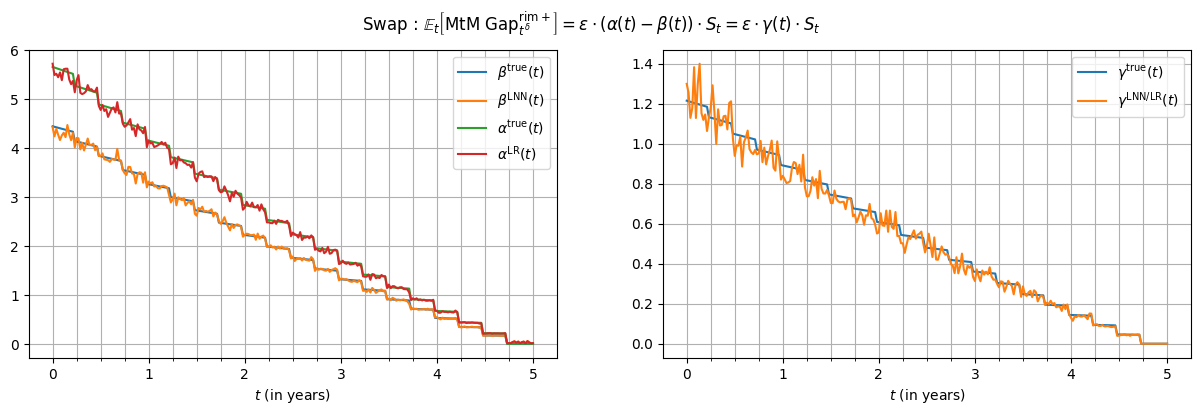

In [85]:
fig, axs = plt.subplots(figsize=(15, 4), ncols=2)
axs[0].plot(time_grid, beta_vals, label='$\\beta^{\\text{true}}(t)$')
axs[0].plot(time_grid, beta_vals_lnn, label='$\\beta^{\\text{LNN}}(t)$')
axs[0].plot(time_grid, alpha_vals, label='$\\alpha^{\\text{true}}(t)$')
axs[0].plot(time_grid, alpha_vals_lr, label='$\\alpha^{\\text{LR}}(t)$')
axs[0].set_xlabel('$t$ (in years)')
axs[0].set_xticks(swap_grid, minor=True)
axs[0].grid(which='both')
axs[0].legend()
print(f"MSE beta LNN: {np.mean((beta_vals - beta_vals_lnn)**2):.4f}")
print(f"MSE alpha LR: {np.mean((alpha_vals - alpha_vals_lr)**2):.4f}")
axs[1].plot(time_grid, gamma_vals, label='$\\gamma^{\\text{true}}(t)$')
axs[1].plot(time_grid, gamma_vals_lin, label='$\\gamma^{\\text{LNN/LR}}(t)$')
axs[1].set_xlabel('$t$ (in years)')
axs[1].set_xticks(swap_grid, minor=True)
axs[1].grid(which='both')
axs[1].legend()
print(f"MSE gamma LNN: {np.mean((gamma_vals - gamma_vals_lin)**2):.4f}")
plt.suptitle('Swap : $\\mathbb{E}_t\\left[\\text{MtM Gap}_{t^\\delta}^{\\text{rim} +}\\right] = \\varepsilon \\cdot \\left( \\alpha(t) - \\beta(t) \\right) \\cdot S_t = \\varepsilon \\cdot \\gamma(t) \\cdot S_t$')
plt.show()

As in the previous section, if we did not had access to the explicit formula of  $\mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]$ by the explicit formula of the functions $q_t$ and $s_t$, we could still validate our results with a twin Monte-Carlo method for quantile regression. Indeed, it can be shown that we have the following control bound for the value-at-risk estimate at time $t$:
$$
\left\lVert \mathbb{P}\left[ \text{MtM Gap}_{t^\delta} \ge \hat q_t(S_t) \vert S_t \right] - \varepsilon \right\rVert^2_{\mathbb{P}, 2}
= \varepsilon^2 - \varepsilon \left(\mathbb{P}\left[\text{MtM Gap}^{(1)}_{t^\delta}>\hat q_t(S_t)\right] + \mathbb{P}\left[\text{MtM Gap}^{(2)}_{t^\delta}>\hat q_t(S_t)\right] + \mathbb{P}\left[\text{MtM Gap}^{(1)}_{t^\delta} \wedge \text{MtM Gap}^{(2)}_{t^\delta} > \hat q_t(S_t)\right]\right),
$$
where $\text{MtM Gap}_{t^\delta}^{(1)}$ and $\text{MtM Gap}_{t^\delta}^{(2)}$ are defined as in the previous section. We can then approximate the error empirically.

In [86]:
varerr_swap_lnn_twin  = epsilon**2 - epsilon * np.mean(
    (mg_swap_paths>var_mg_swap_lnn_paths) + (mg_twin_swap_paths>var_mg_swap_lnn_paths) + (np.minimum(mg_swap_paths, mg_twin_swap_paths)>var_mg_swap_lnn_paths),
    axis=0
)

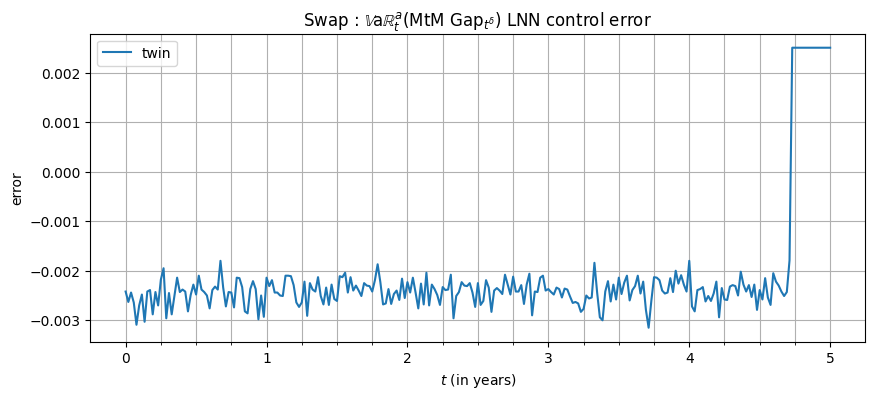

In [87]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, varerr_swap_lnn_twin, label='twin')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('error')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.legend()
ax.set_title('Swap : $\\mathbb{V}\\text{a}\\mathbb{R}_t^a(\\text{MtM Gap}_{t^\\delta})$ LNN control error')
plt.show()

Notice that a similar but more complex control bound can be derived for the expected shortfall estimate.

Finally, we can validate our estimation of $q_t$ and $s_t$ by comparing them with a nested Monte-Carlo simulation. Given a trajectory $(S_t)$, we approximate $\mathbb{V}\text{a}\mathbb{R}_t^a(\text{MtM Gap}_{t^\delta})$ by the empirical quantile and $\mathbb{ES}_t^a$ by an empirical mean of samples above empirical value-at-risk,  for $K$ iid samples of $\text{MtM Gap}_{t^\delta}$ knowing $S_t$ samples, as for the twin Monte-Carlo method. Thus, we generate $K = \sqrt{M}$ new samples of $\text{MtM Gap}_{t^\delta}$ for each pricing date $(t, S_t)$.

In [88]:
def gen_var_es_mg_swap_nmc(S_paths):
    var = np.zeros_like(S_paths)
    es  = np.zeros_like(S_paths)
    for i in tqdm(range(N), desc='Processing nested Monte Carlo'):
        new_points  = S_paths[:, i]*np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*np.random.normal(0, 1, size=(int(np.sqrt(M)), len(S_paths))))
        new_mtm     = nom*f_vals[i]*(np.exp(-kappa*time_grid[i+1])*new_points-np.exp(-kappa*time_grid[i])*S_paths[:, i])
        var[:, i]   = np.quantile(new_mtm, a, axis=0)
        es[:, i]    = np.mean(new_mtm, where=new_mtm>=var[:, i], axis=0)
    return var, es

var_mg_swap_nmc_paths, es_mg_swap_nmc_paths = gen_var_es_mg_swap_nmc(S_paths)
econd_mgprim_swap_nmc_paths                 = epsilon * (es_mg_swap_nmc_paths - var_mg_swap_nmc_paths)

Processing nested Monte Carlo: 100%|██████████| 260/260 [00:06<00:00, 39.07it/s]


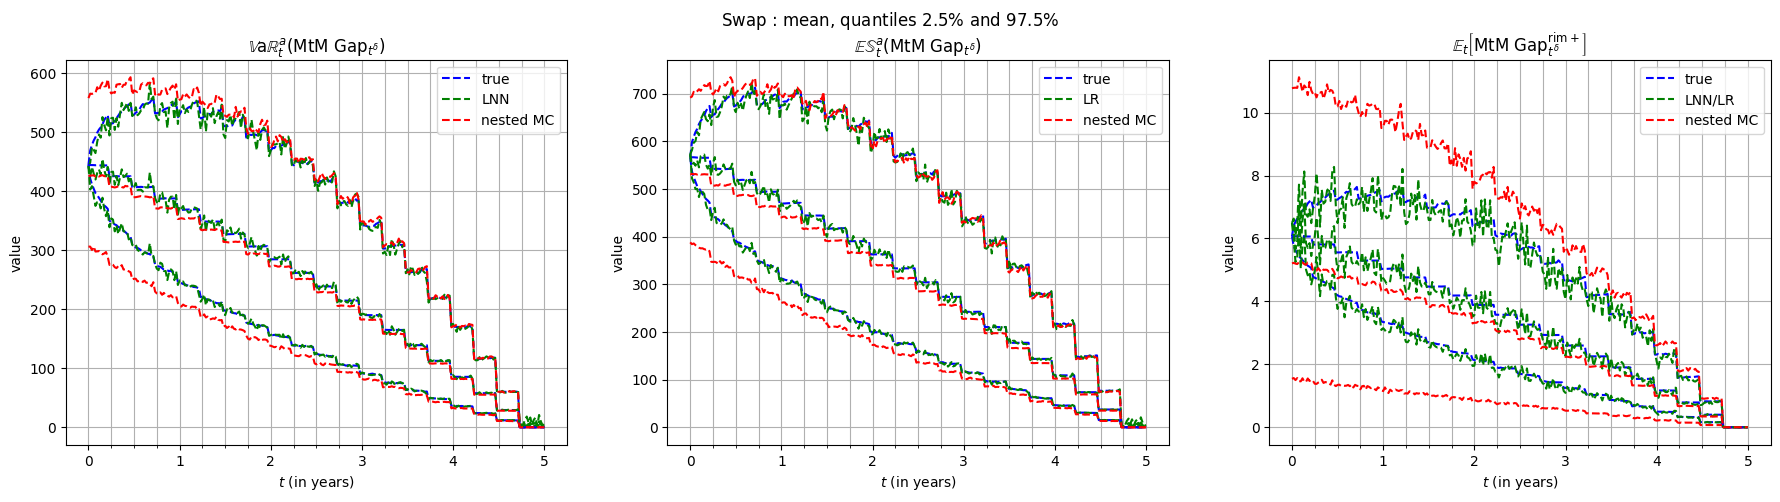

In [89]:
fig, axs = plt.subplots(figsize=(22, 5), ncols=3)

def plot_fig(i, res1, res2, res3, lab1, lab2, lab3):
    axs[i].plot(time_grid, np.quantile(res1, 0.975, axis=0), label=lab1, linestyle='--', color='blue')
    axs[i].plot(time_grid, np.quantile(res2, 0.975, axis=0), label=lab2, linestyle='--', color='green')
    axs[i].plot(time_grid, np.quantile(res3, 0.975, axis=0), label=lab3, linestyle='--', color='red')

    axs[i].plot(time_grid, np.quantile(res1, 0.025, axis=0), linestyle='--', color='blue')
    axs[i].plot(time_grid, np.quantile(res2, 0.025, axis=0), linestyle='--', color='green')
    axs[i].plot(time_grid, np.quantile(res3, 0.025, axis=0), linestyle='--', color='red')

    axs[i].plot(time_grid, np.mean(res1, axis=0), linestyle='--', color='blue')
    axs[i].plot(time_grid, np.mean(res2, axis=0), linestyle='--', color='green')
    axs[i].plot(time_grid, np.mean(res3, axis=0), linestyle='--', color='red')
    axs[i].set_xlabel('$t$ (in years)')
    axs[i].set_ylabel('value')
    axs[i].set_xticks(swap_grid, minor=True)
    axs[i].grid(which='both')
    axs[i].legend()

plot_fig(0, var_mg_swap_paths, var_mg_swap_lnn_paths, var_mg_swap_nmc_paths, 'true', 'LNN', 'nested MC')
axs[0].set_title('$\\mathbb{V}\\text{a}\\mathbb{R}_t^a(\\text{MtM Gap}_{t^\\delta})$')
plot_fig(1, es_mg_swap_paths, es_mg_swap_lr_paths, es_mg_swap_nmc_paths, 'true', 'LR', 'nested MC')
axs[1].set_title('$\\mathbb{ES}_t^a(\\text{MtM Gap}_{t^\\delta})$')
plot_fig(2, econd_mgprim_swap_paths, econd_mgprim_swap_lin_paths, econd_mgprim_swap_nmc_paths, 'true', 'LNN/LR', 'nested MC')
axs[2].set_title('$\\mathbb{E}_t\\left[\\text{MtM Gap}_{t^\\delta}^{\\text{rim} +}\\right]$')
plt.suptitle('Swap : mean, quantiles $2.5\\%$ and $97.5\\%$')
plt.show()

#### <span style="color:#00B8DE"> Question 4. </span>

Now, the CVA can be computed using our previous estimators $\hat q_t(S_t)$ of $\mathbb{V}\text{a}\mathbb{R}_t^a(\text{MtM Gap}_{t^\delta})$ and $\hat s_t(S_t)$ of $\mathbb{ES}_t^a(\text{MtM Gap}_{t^\delta})$, approximating the integral numerically, and taking an empirical mean over our $M$ iid samples $\hat q_t\left(S_t^{(m)}\right)$ and $\hat s_t\left(S_t^{(m)}\right)$.

Notice that we can validate our results using empirical mean for the outer expecation and the formula or nested Monte-Carlo simulation for the inner conditional expectation, but also using the following formula for a swap:
$$
\text{CVA}^\text{rim}_0 = \text{Nom} \cdot S_0 \cdot \gamma \cdot \int_0^T C(t) \cdot e^{-\gamma t} dt.
$$

In [90]:
c_vals      = gamma_vals * epsilon/(nom * np.exp(-kappa*time_grid))
cvarim_swap = nom*S0*np.trapezoid(c_vals * np.exp(-gamma*time_grid) * gamma, dx=delta)

In [91]:
cvarim_swap_mc  = calc_cva(econd_mgprim_swap_paths)
cvarim_swap_lin = calc_cva(econd_mgprim_swap_lin_paths)
cvarim_swap_nmc = calc_cva(econd_mgprim_swap_nmc_paths)

print(f"CVA swap formula: {cvarim_swap:.4f}")
print(f"CVA swap using MC for outer expectation and formula for conditional expectation: {cvarim_swap_mc:.4f}")
print(f"CVA swap using MC for outer expectation and LNN/LR for conditional expectation: {cvarim_swap_lin:.4f}")
print(f"CVA swap using MC for outer expectation and nested MC for conditional expectation: {cvarim_swap_nmc:.4f}")

CVA swap formula: 1.3736
CVA swap using MC for outer expectation and formula for conditional expectation: 1.3782
CVA swap using MC for outer expectation and LNN/LR for conditional expectation: 1.3499
CVA swap using MC for outer expectation and nested MC for conditional expectation: 1.1849


### <span style="color:#008000"> Interest Rate Call Option

#### <span style="color:#00B8DE"> Question 5. </span>

In the case of the call, as in previous section, we do not expect to have linear functions $q_t(S_t) =  \mathbb{V}\text{a}\mathbb{R}_t^a(\text{MtM Gap}_{t^\delta})$ nor $s_t(S_t) = \mathbb{ES}_t^a(\text{MtM Gap}_{t^\delta})$ anymore. Thus, we will approximate these functions respectively with a non-linear neural network and a polynomial regression model ???? Our results will be validated with twin Monte-Carlo method and nested Monte-Carlo simulation, as in the previous questions (but loosing analytical formulas).

We train a non-linear neural network and a polynomial regression model at each pricing date $t$ using $\left(S_t^{(m)}, \text{MtM Gap}_{t^\delta}^{+ (m)}\right)_m$ and calculate the paths $\left(q_t^{\text{PR}}(S_t)\right)$ and $\left(s_t^{\text{PR}}(S_t)\right)$ for our different trajectories of $(S_t)$.

In [92]:
var_mg_call_nlnn_paths      = np.zeros_like(S_paths)
nepochs                     = 300
train_losses_var_call_nlnn  = np.zeros((N+1, nepochs))
for i in tqdm(range(N+1), desc='Training nonlinear neural network'):
    x       = torch.tensor(S_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    x       = (x - x.mean())/x.std() if x.std() > 0 else x
    y       = torch.tensor(mg_call_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    model   = NonLinearNN(input_dim=1)
    crit    = lambda y_hat, y: torch.mean(pinball_loss(y_hat, y, epsilon))
    optim   = torch.optim.Adam(model.parameters(), lr=5*10**(-2))
    for epoch in range(nepochs):
        model.train()
        optim.zero_grad()
        loss = crit(model(x), y)
        loss.backward()
        optim.step()
        train_losses_var_call_nlnn[i, epoch] = loss.item()
    var_mg_call_nlnn_paths[:, i] = model(x).detach().numpy().reshape(-1)

Training nonlinear neural network: 100%|██████████| 261/261 [02:23<00:00,  1.81it/s]


In [93]:
es_mg_call_pr_paths = np.zeros_like(S_paths)
for i in range(N+1):
    model   = LinearRegression(fit_intercept=False)
    poly    = PolynomialFeatures(degree=3, include_bias=True)
    S_poly  = poly.fit_transform(S_paths[:, i].reshape(-1, 1))
    model.fit(S_poly, pinball_loss_np(var_mg_call_nlnn_paths[:, i], mg_call_paths[:, i], epsilon))
    es_mg_call_pr_paths[:, i] = model.predict(S_poly)

In [94]:
econd_mgprim_call_nlin_paths = epsilon * (es_mg_call_pr_paths - var_mg_call_nlnn_paths)

As in question 3, Let us validate our result for the value-at-risk with a twin Monte-Carlo method.

In [95]:
varerr_call_nlnn_twin  = epsilon**2 - epsilon * np.mean(
    (mg_call_paths>var_mg_call_nlnn_paths) + (mg_twin_call_paths>var_mg_call_nlnn_paths) + (np.minimum(mg_call_paths, mg_twin_call_paths)>var_mg_call_nlnn_paths),
    axis=0
)

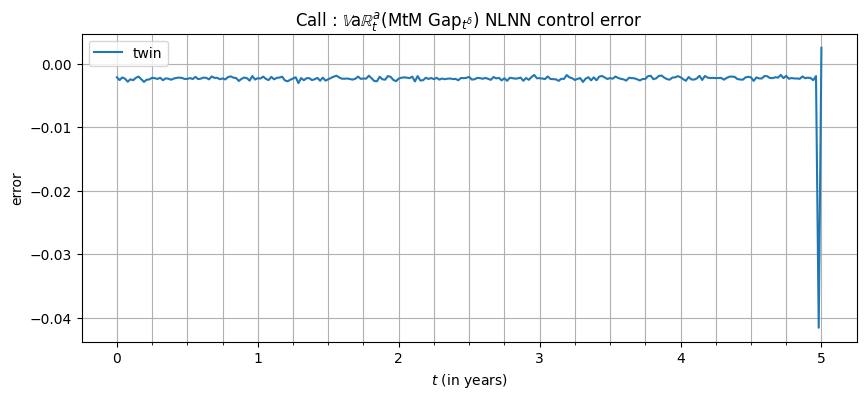

In [96]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, varerr_call_nlnn_twin, label='twin')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('error')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('Call : $\\mathbb{V}\\text{a}\\mathbb{R}_t^a(\\text{MtM Gap}_{t^\\delta})$ NLNN control error')
ax.legend()
plt.show()

Finally, we can validate our estimations of $q_t$ and $s_t$ by comparing them with a nested Monte-Carlo simulation.

In [97]:
def gen_var_es_mg_call_nmc(S_paths):
    var = np.zeros_like(S_paths)
    es  = np.zeros_like(S_paths)
    for i in tqdm(range(N-1), desc='Processing nested Monte Carlo'):
        d1          = (np.log(S_paths[:, i]/S0) + (kappa + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i])
        mtm         = np.exp(-r*(T-time_grid[i]))*(S_paths[:, i]*np.exp(kappa*(T-time_grid[i]))*norm.cdf(d1) - S0*norm.cdf(d2))
        new_points  = S_paths[:, i]*np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*np.random.normal(0, 1, size=(int(np.sqrt(M)), len(S_paths))))
        d1          = (np.log(new_points/S0) + (kappa + 0.5*sigma**2)*(T-time_grid[i+1])) / (sigma*np.sqrt(T-time_grid[i+1]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i+1])
        new_mtms    = np.exp(-r*(T-time_grid[i+1]))*(new_points*np.exp(kappa*(T-time_grid[i+1]))*norm.cdf(d1) - S0*norm.cdf(d2))
        new_gap     = beta(time_grid[i+1])*new_mtms - beta(time_grid[i])*mtm
        var[:, i]   = np.quantile(new_gap, a, axis=0)
        es[:, i]    = np.mean(new_gap, where=new_gap>=var[:, i], axis=0)
    return var, es

var_mg_call_nmc_paths, es_mg_call_nmc_paths = gen_var_es_mg_call_nmc(S_paths)
econd_mgprim_call_nmc_paths                 = epsilon * (es_mg_call_nmc_paths - var_mg_call_nmc_paths)

Processing nested Monte Carlo: 100%|██████████| 259/259 [00:22<00:00, 11.37it/s]


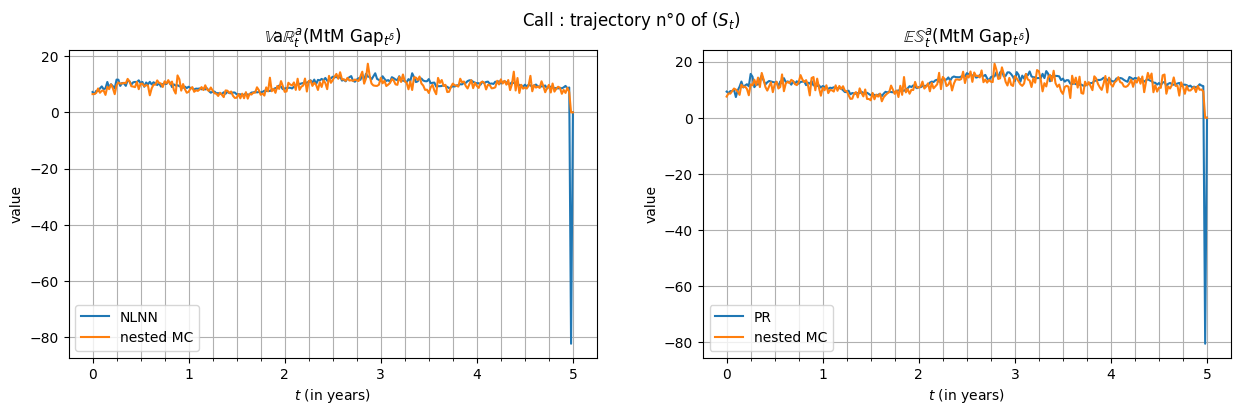

In [98]:
fig, axs = plt.subplots(figsize=(15, 4), ncols=2)
axs[0].plot(time_grid, var_mg_call_nlnn_paths[0], label='NLNN')
axs[0].plot(time_grid, var_mg_call_nmc_paths[0], label='nested MC')
axs[0].set_xlabel('$t$ (in years)')
axs[0].set_ylabel('value')
axs[0].set_xticks(swap_grid, minor=True)
axs[0].grid(which='both')
axs[0].legend()
axs[0].set_title('$\\mathbb{V}\\text{a}\\mathbb{R}_t^a(\\text{MtM Gap}_{t^\\delta})$')

axs[1].plot(time_grid, es_mg_call_pr_paths[0], label='PR')
axs[1].plot(time_grid, es_mg_call_nmc_paths[0], label='nested MC')
axs[1].set_xlabel('$t$ (in years)')
axs[1].set_ylabel('value')
axs[1].set_xticks(swap_grid, minor=True)
axs[1].grid(which='both')
axs[1].legend()
axs[1].set_title('$\\mathbb{ES}_t^a(\\text{MtM Gap}_{t^\\delta})$')
plt.suptitle('Call : trajectory n°0 of $(S_t)$')
plt.show()

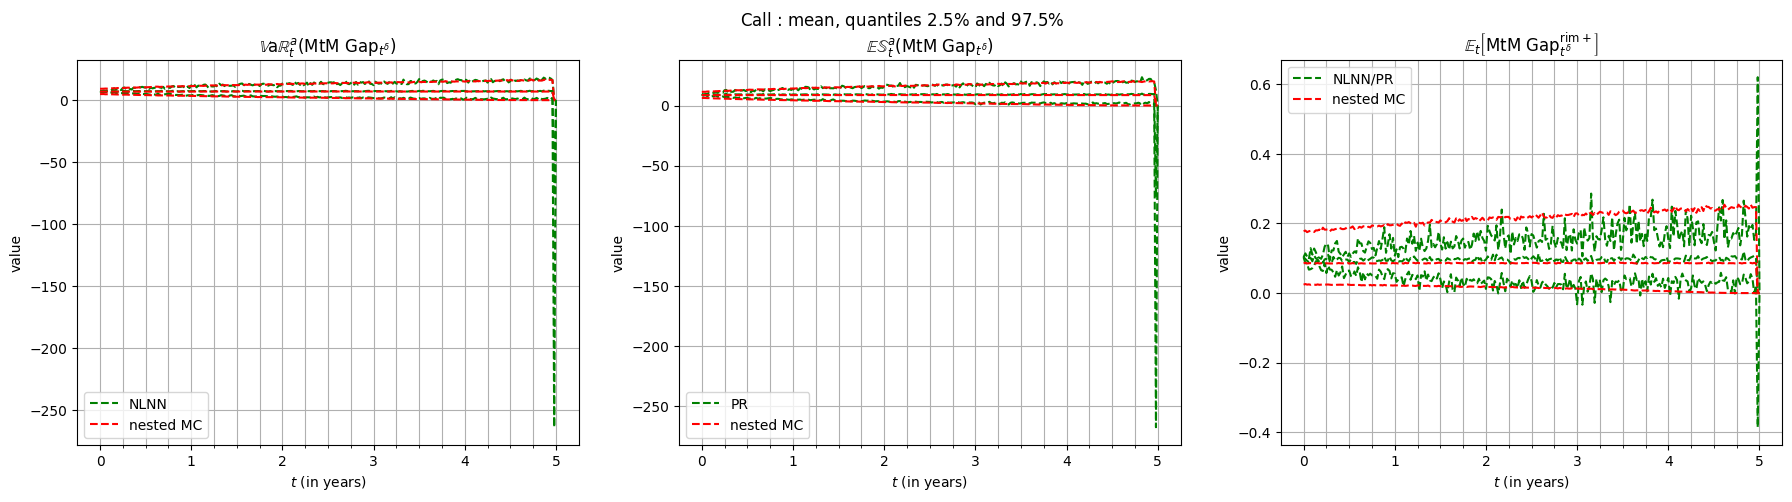

In [99]:
fig, axs = plt.subplots(figsize=(22, 5), ncols=3)

def plot_fig(i, res1, res2, lab1, lab2):
    axs[i].plot(time_grid, np.quantile(res1, 0.975, axis=0), label=lab1, linestyle='--', color='green')
    axs[i].plot(time_grid, np.quantile(res2, 0.975, axis=0), label=lab2, linestyle='--', color='red')

    axs[i].plot(time_grid, np.quantile(res1, 0.025, axis=0), linestyle='--', color='green')
    axs[i].plot(time_grid, np.quantile(res2, 0.025, axis=0), linestyle='--', color='red')

    axs[i].plot(time_grid, np.mean(res1, axis=0), linestyle='--', color='green')
    axs[i].plot(time_grid, np.mean(res2, axis=0), linestyle='--', color='red')
    axs[i].set_xlabel('$t$ (in years)')
    axs[i].set_ylabel('value')
    axs[i].set_xticks(swap_grid, minor=True)
    axs[i].grid(which='both')
    axs[i].legend()

plot_fig(0, var_mg_call_nlnn_paths, var_mg_call_nmc_paths, 'NLNN', 'nested MC')
axs[0].set_title('$\\mathbb{V}\\text{a}\\mathbb{R}_t^a(\\text{MtM Gap}_{t^\\delta})$')
plot_fig(1, es_mg_call_pr_paths, es_mg_call_nmc_paths, 'PR', 'nested MC')
axs[1].set_title('$\\mathbb{ES}_t^a(\\text{MtM Gap}_{t^\\delta})$')
plot_fig(2, econd_mgprim_call_nlin_paths, econd_mgprim_call_nmc_paths, 'NLNN/PR', 'nested MC')
axs[2].set_title('$\\mathbb{E}_t\\left[\\text{MtM Gap}_{t^\\delta}^{\\text{rim} +}\\right]$')
plt.suptitle('Call : mean, quantiles $2.5\\%$ and $97.5\\%$')
plt.show()

As in Question 4., the CVA can be computed using our previous estimators $\hat q_t(S_t)$ and $\hat s_t(S_t)$, approximating the integral numerically, and taking an empirical mean over our $M$ iid samples $\hat u_t(S_t^{(m)})$.

In [100]:
cvarim_call_nlin    = calc_cva(econd_mgprim_call_nlin_paths)
cvarim_call_nmc     = calc_cva(econd_mgprim_call_nmc_paths)

print(f"CVA call using MC for outer expectation and NLNN/PR for conditional expectation: {cvarim_call_nlin:.4f}")
print(f"CVA call using MC for outer expectation and nested MC for conditional expectation: {cvarim_call_nmc:.4f}")

CVA call using MC for outer expectation and NLNN/PR for conditional expectation: 0.0380
CVA call using MC for outer expectation and nested MC for conditional expectation: 0.0337


#### <span style="color:#00B8DE"> Question 6. </span>

In this question, we want to calculate the CVA with RIM simultaneously for different levels of $a$. As opposed to the single $a$ approach where we should do again the training procedure for each $a$ considered, we introduce here a multi $a$ approach. A natural way to do so is to randomize $a$ and express it as a feature of the neural network for estimating value-at-risk. We can then still calculate the expected shortfall by linear or polynomial regression for each value of $a$, as it is not time consuming.

However, a point of attention is the problem of crossing quantile curves, i.e. the violation of the monotonicity with respect to $a$. Indeed, the value-at-risk should be a decreasing function of $a$. There exist many ways to handle this issue, such as penalizing the loss function by the begative part of the derivative of the neural network function with respect to $a$. Another way is to use a finite set of values of $a$ and do linear interpolation.

Here, for the sake of simplicity, we only focus on the basic version described above and randomize $a$ with a uniform distribution: $a \sim \mathcal{U}\left([0.85, 0.99]\right)$.

### <span style="color:#008000"> Interest Rate Swap

We will test this multi $a$ learning approach only for the swap, as we have the closed form to validate our results. Similar computations can be done for the call option. Notice that we can't use anymore a one layer linear neural network since we have to take into account the feature $a$ in the neural network function. We will evaluate the results for $a = 90\%, 95\%, 99\%$.

In [101]:
a_samples       = 0.85 + (0.99-0.85)*torch.rand(M, dtype=torch.float32)
epsilon_samples = 1-a_samples
a_vals          = np.array([0.90, 0.95, 0.975])

In [102]:
var_mg_swap_nlnn_mul_paths      = np.zeros((M, N+1, len(a_vals)))
nepochs                         = 30
train_losses_var_swap_nlnn_mul  = np.zeros((N+1, nepochs))
for i in tqdm(range(N+1), desc='Training nonlinear neural network'):
    x           = torch.stack((torch.tensor(S_paths[:, i], dtype=torch.float32), a_samples), dim=1)
    y           = torch.tensor(mg_swap_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    model       = NonLinearNN(input_dim=2)
    crit        = lambda y_hat, y: torch.mean(pinball_loss(y_hat, y, epsilon_samples))
    optim   = torch.optim.Adam(model.parameters(), lr=5*10**(-2))
    for epoch in range(nepochs):
        model.train()
        optim.zero_grad()
        loss = crit(model(x), y)
        loss.backward()
        optim.step()
        train_losses_var_swap_nlnn_mul[i, epoch] = loss.item()
    for j, a_val in enumerate(a_vals):
        var_mg_swap_nlnn_mul_paths[:, i, j] = model(torch.tensor(np.column_stack((S_paths[:, i], np.full(M, a_val))), dtype=torch.float32)).detach().numpy().reshape(-1)

Training nonlinear neural network: 100%|██████████| 261/261 [05:44<00:00,  1.32s/it]


In [103]:
es_mg_swap_lr_mul_paths = np.zeros((M, N+1, len(a_vals)))
for j, a_val in enumerate(a_vals):
    for i in range(N+1):
        model = LinearRegression(fit_intercept=False)
        model.fit(S_paths[:, i].reshape(-1, 1), pinball_loss_np(var_mg_swap_nlnn_mul_paths[:, i, j], mg_swap_paths[:, i], 1-a_val))
        es_mg_swap_lr_mul_paths[:, i, j] = model.predict(S_paths[:, i].reshape(-1, 1))

In [104]:
econd_MtMgaprim_swap_nlin_mul_paths  = (1-a_vals) * (es_mg_swap_lr_mul_paths - var_mg_swap_nlnn_mul_paths)

In [105]:
var_mg_swap_mul_paths       = np.zeros((M, N+1, len(a_vals)))
es_mg_swap_mul_paths        = np.zeros((M, N+1, len(a_vals)))
econd_mgprim_swap_mul_paths = np.zeros((M, N+1, len(a_vals)))
for j, a_val in enumerate(a_vals):
    res                                     = gen_var_mg_swap(S_paths, a_val)
    var_mg_swap_mul_paths[:, :, j]          = res[1]
    res                                     = gen_es_mg_swap(S_paths, a_val)
    es_mg_swap_mul_paths[:, :, j]           = res[1]
    econd_mgprim_swap_mul_paths[:, :, j]    = (1-a_val) * (es_mg_swap_mul_paths[:, :, j] - var_mg_swap_mul_paths[:, :, j])

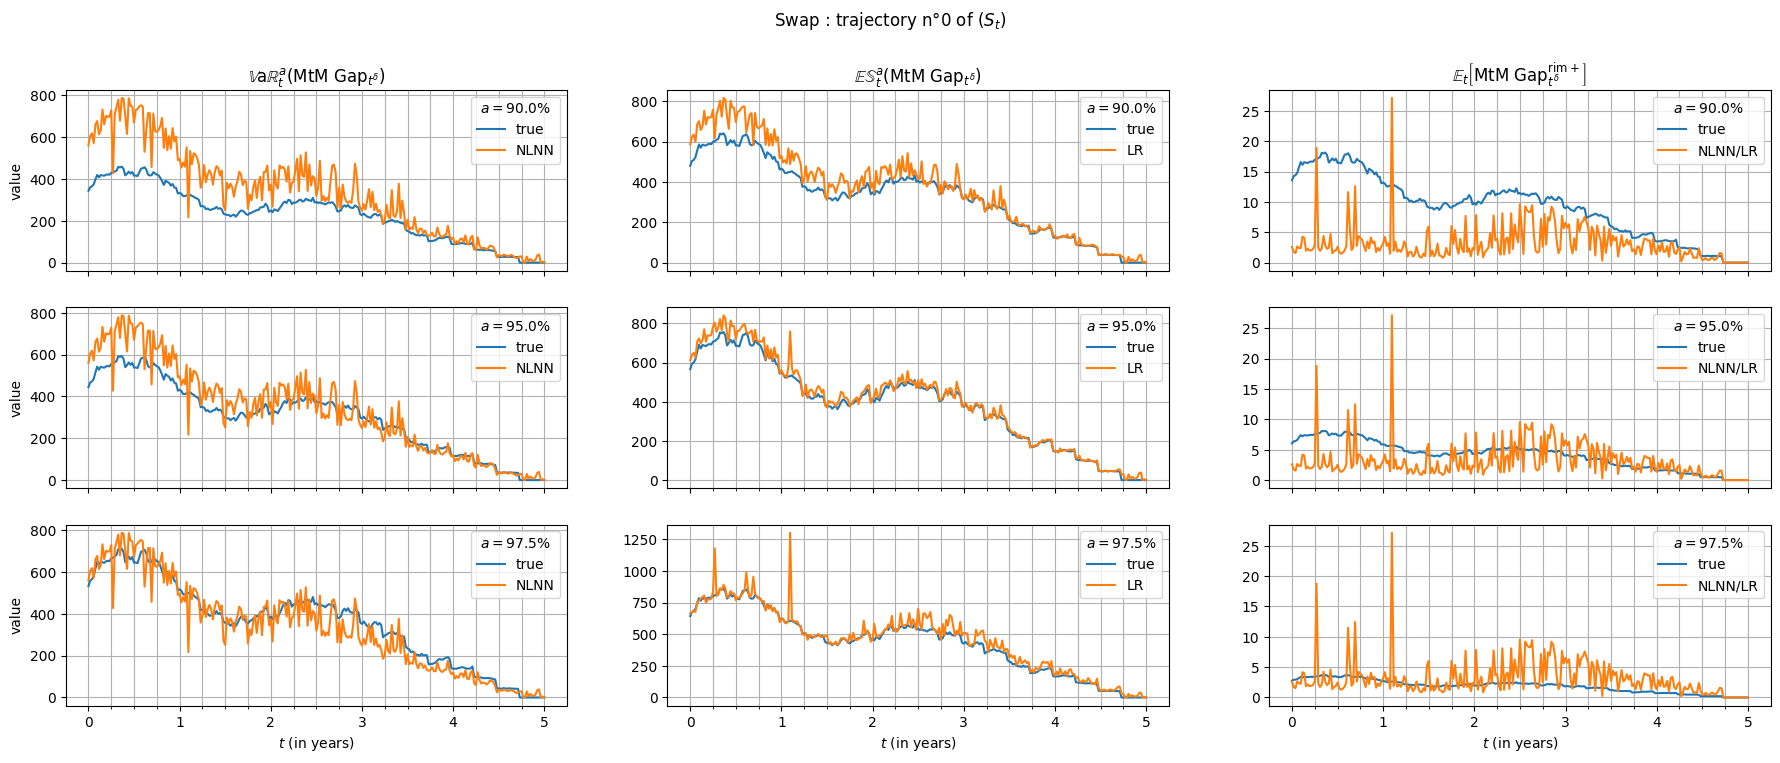

In [106]:
fig, axs = plt.subplots(figsize=(22, 8), ncols=3, nrows=len(a_vals), sharex=True)

axs[0, 0].set_title('$\\mathbb{V}\\text{a}\\mathbb{R}_t^a(\\text{MtM Gap}_{t^\\delta})$')
axs[0, 1].set_title('$\\mathbb{ES}_t^a(\\text{MtM Gap}_{t^\\delta})$')
axs[0, 2].set_title('$\\mathbb{E}_t\\left[\\text{MtM Gap}_{t^\\delta}^{\\text{rim} +}\\right]$')
axs[len(a_vals)-1, 0].set_xlabel('$t$ (in years)')
axs[len(a_vals)-1, 1].set_xlabel('$t$ (in years)')
axs[len(a_vals)-1, 2].set_xlabel('$t$ (in years)')

for j, a_val in enumerate(a_vals):
    
    axs[j, 0].plot(time_grid, var_mg_swap_mul_paths[0, :, j], label=f'true')
    axs[j, 0].plot(time_grid, var_mg_swap_nlnn_mul_paths[0, :, j], label=f'NLNN')
    axs[j, 0].set_ylabel(f'value')
    axs[j, 0].set_xticks(swap_grid, minor=True)
    axs[j, 0].grid(which='both')
    axs[j, 0].legend(title=f'$a = ${a_val:.1%}')
    
    axs[j, 1].plot(time_grid, es_mg_swap_mul_paths[0, :, j], label=f'true')
    axs[j, 1].plot(time_grid, es_mg_swap_lr_mul_paths[0, :, j], label=f'LR')
    axs[j, 1].set_xticks(swap_grid, minor=True)
    axs[j, 1].grid(which='both')
    axs[j, 1].legend(title=f'$a = ${a_val:.1%}')

    axs[j, 2].plot(time_grid, econd_mgprim_swap_mul_paths[0, :, j], label=f'true')
    axs[j, 2].plot(time_grid, econd_MtMgaprim_swap_nlin_mul_paths[0, :, j], label=f'NLNN/LR')
    axs[j, 2].set_xticks(swap_grid, minor=True)
    axs[j, 2].grid(which='both')
    axs[j, 2].legend(title=f'$a = ${a_val:.1%}')

plt.suptitle('Swap : trajectory n°0 of $(S_t)$')
plt.show()

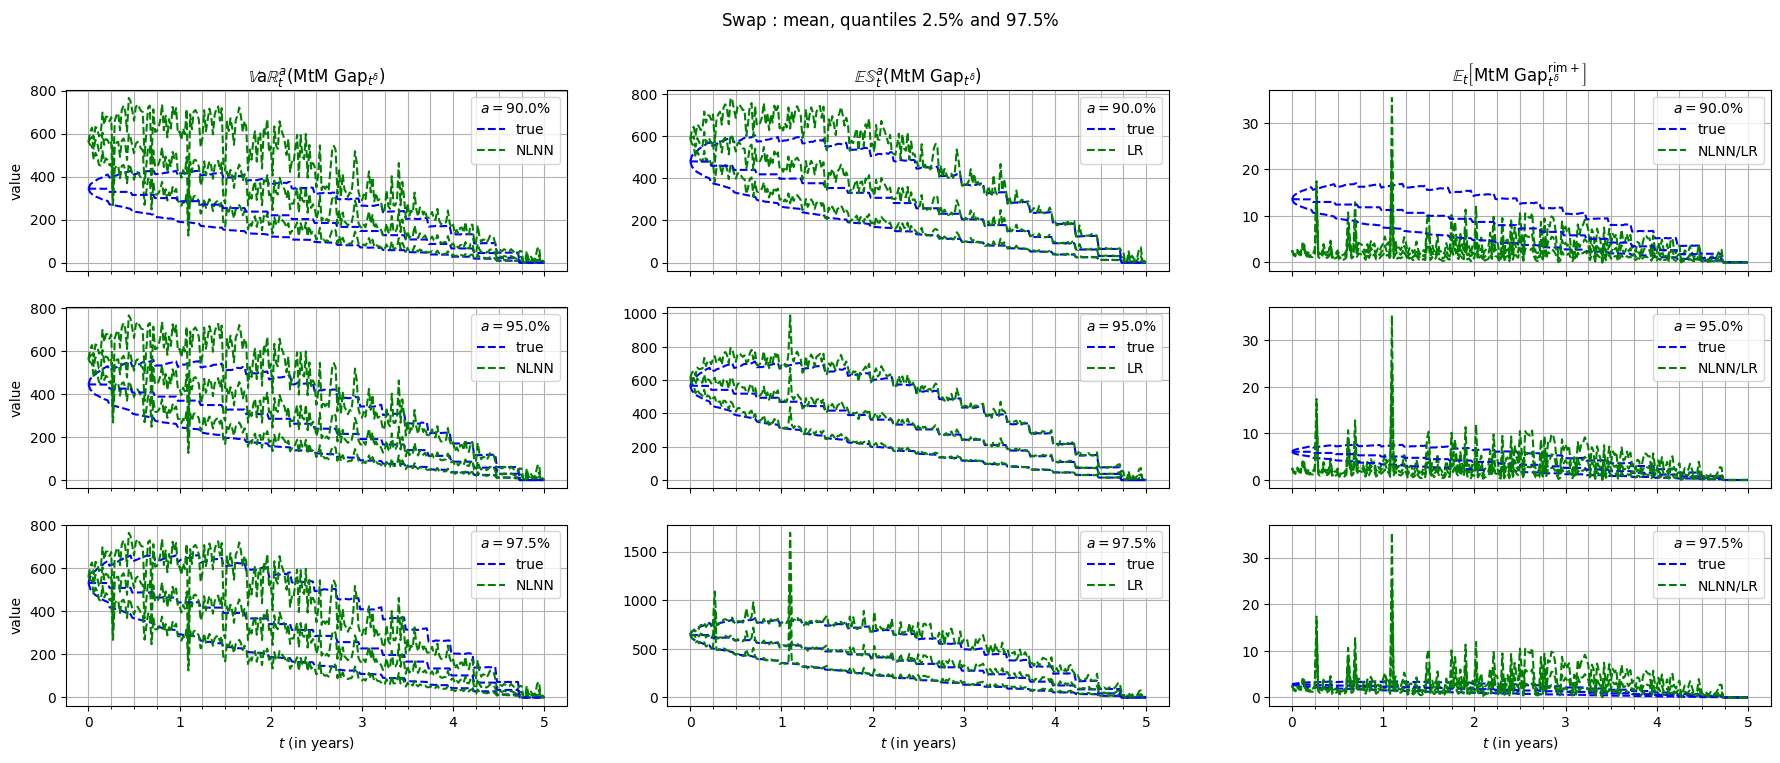

In [107]:
fig, axs = plt.subplots(figsize=(22, 8), ncols=3, nrows=len(a_vals), sharex=True)

def plot_fig(i, j, res1, res2, lab1, lab2):
    axs[i, j].plot(time_grid, np.quantile(res1, 0.975, axis=0), label=lab1, linestyle='--', color='blue')
    axs[i, j].plot(time_grid, np.quantile(res2, 0.975, axis=0), label=lab2, linestyle='--', color='green')

    axs[i, j].plot(time_grid, np.quantile(res1, 0.025, axis=0), linestyle='--', color='blue')
    axs[i, j].plot(time_grid, np.quantile(res2, 0.025, axis=0), linestyle='--', color='green')

    axs[i, j].plot(time_grid, np.mean(res1, axis=0), linestyle='--', color='blue')
    axs[i, j].plot(time_grid, np.mean(res2, axis=0), linestyle='--', color='green')
    axs[i, j].set_xticks(swap_grid, minor=True)
    axs[i, j].grid(which='both')
    axs[i, j].legend(title=f'$a = ${a_vals[i]:.1%}')
    if j == 0:
        axs[i, j].set_ylabel('value')
    if i == len(a_vals)-1:
        axs[i, j].set_xlabel('$t$ (in years)')

for i, a_val in enumerate(a_vals):
    plot_fig(i, 0, var_mg_swap_mul_paths[:, :, i], var_mg_swap_nlnn_mul_paths[:, :, i], 'true', 'NLNN')
    plot_fig(i, 1, es_mg_swap_mul_paths[:, :, i], es_mg_swap_lr_mul_paths[:, :, i], 'true', 'LR')
    plot_fig(i, 2, econd_mgprim_swap_mul_paths[:, :, i], econd_MtMgaprim_swap_nlin_mul_paths[:, :, i], 'true', 'NLNN/LR')

axs[0, 0].set_title('$\\mathbb{V}\\text{a}\\mathbb{R}_t^a(\\text{MtM Gap}_{t^\\delta})$')
axs[0, 1].set_title('$\\mathbb{ES}_t^a(\\text{MtM Gap}_{t^\\delta})$')
axs[0, 2].set_title('$\\mathbb{E}_t\\left[\\text{MtM Gap}_{t^\\delta}^{\\text{rim} +}\\right]$')
        
plt.suptitle('Swap : mean, quantiles $2.5\\%$ and $97.5\\%$')
plt.show()



In [108]:
for j, a_val in enumerate(a_vals):
    cvarim_swap_nlin_mul    = calc_cva(econd_MtMgaprim_swap_nlin_mul_paths[:, :, j])
    cvarim_swap_mc_mul      = calc_cva(econd_mgprim_swap_mul_paths[:, :, j])
    c_vals                  = gamma_vals * (1-a_val)/(nom * np.exp(-kappa*time_grid))
    cvarim_swap             = nom*S0*np.trapezoid(c_vals * np.exp(-gamma*time_grid) * gamma, dx=delta)
    print(f"CVA swap formula ({a_val:.1%}): {cvarim_swap:.4f}")
    print(f"CVA swap using MC for outer expectation and formula for conditional expectation ({a_val:.1%}): {cvarim_swap_mc_mul:.4f}")
    print(f"CVA swap using MC for outer expectation and NLNN/LR for conditional expectation ({a_val:.1%}): {cvarim_swap_nlin_mul:.4f}")
    print('-----------------------------------------------------------------------------------------------')

CVA swap formula (90.0%): 2.7473
CVA swap using MC for outer expectation and formula for conditional expectation (90.0%): 3.0850
CVA swap using MC for outer expectation and NLNN/LR for conditional expectation (90.0%): 0.9498
-----------------------------------------------------------------------------------------------
CVA swap formula (95.0%): 1.3736
CVA swap using MC for outer expectation and formula for conditional expectation (95.0%): 1.3782
CVA swap using MC for outer expectation and NLNN/LR for conditional expectation (95.0%): 0.9522
-----------------------------------------------------------------------------------------------
CVA swap formula (97.5%): 0.6868
CVA swap using MC for outer expectation and formula for conditional expectation (97.5%): 0.6299
CVA swap using MC for outer expectation and NLNN/LR for conditional expectation (97.5%): 0.9534
-----------------------------------------------------------------------------------------------
